In [1]:
import re
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import seaborn as sns
import xarray as xr
import functools
from IPython.display import clear_output
import datetime
import random
from salishsea_tools import geo_tools, geo_tools, tidetools, data_tools

%matplotlib inline
plt.rcParams['image.cmap'] = 'jet'

In [21]:
# converts lons/lats like this "124° 01.400" to decimal format
def strLonLatToDec(lstr):
    if type(lstr) is not str:
        return(np.NaN)
    lstr = lstr.replace(u'°',' ')
    lstr = lstr.split()
    return (int(lstr[0])+float(lstr[1])/60.0)

In [24]:
# Grab tracer data

#  '/ocean/rich/home/metro/venus_adcp/PSF/bottle/PSF_2015bottle_RPedit.xls'
tracer_df = pd.read_excel('/ocean/rich/home/metro/venus_adcp/PSF/bottle/PSF_2015bottle_RPeditfinal.xls')
tracer_df = tracer_df[~pd.isnull(tracer_df["Date"])]
#tracer_df["Date"] = pd.to_datetime(tracer_df["Date"])
tracer_df = tracer_df.sort_values("Date")
tracer_df["DECIMAL_LON"] = (tracer_df["Longitude"].apply(strLonLatToDec))*(-1)
tracer_df["DECIMAL_LAT"] = (tracer_df["Latitude"].apply(strLonLatToDec))
tracer_df["STATION_LAT"] =  tracer_df.groupby("Station ID")["DECIMAL_LAT"].transform(np.median)
tracer_df["STATION_LON"] =  tracer_df.groupby("Station ID")["DECIMAL_LON"].transform(np.median)

In [25]:
# Create smaller dataframe with location of stations
station_lon_lat = tracer_df[["Station ID", "STATION_LON", "STATION_LAT"]].drop_duplicates()
station_lon_lat.columns = ["STATION", "LON", "LAT"]

# Add corresponding model points to station data frame
grid_B = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
bathy, X, Y = tidetools.get_bathy_data(grid_B)

def closest_model_point_wrapper(lon, lat):
    try:
        model_point = geo_tools.find_closest_model_point(lon, lat, model_lons = X, model_lats = Y, grid = 'NEMO', land_mask = bathy.mask)
        return(model_point)
    except:
        print("ERROR" + str(lon) + " " + str(lat))
        return(np.nan)
    
station_lon_lat["MODEL_POINT"] = station_lon_lat.apply(lambda row: closest_model_point_wrapper(row[1], row[2]) , axis = 1)
station_lon_lat["MODEL_J"] = station_lon_lat["MODEL_POINT"].apply(lambda x: x[0])
station_lon_lat["MODEL_I"] = station_lon_lat["MODEL_POINT"].apply(lambda x: x[1])

In [32]:
# Choose which values to add to nowcast dataframe

tracers = ["NO3"]

plot_months = ["feb", "mar", "apr", "may", "jun", "jul", "aug", "sep"]

plot_hours = np.array([12])

max_depth = 20
result_depths = xr.open_dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/deptht_428m.nc').deptht.values
depth_indices = np.where(result_depths < max_depth)[0]

station_points = station_lon_lat["MODEL_POINT"]
station_names = station_lon_lat["STATION"]

stations = dict(zip(station_names, station_points))

nowcast_df = pd.read_pickle("/ocean/jpetrie/MEOPAR/analysis-james/nowcast_green_subset/2016_8_4_12_30.pkl")
nowcast_df["DATE"] = pd.to_datetime(nowcast_df["DATE"], infer_datetime_format=True)
#nowcast_df = data_tools.load_nowcast_station_tracers(tracers, stations, months, hours, depth_indices)

In [33]:
nitrate_df = tracer_df[["Station ID", "Date", "DECIMAL_LON", "DECIMAL_LAT","Depth", "Nitrate + Nitrite"]]
nitrate_df.columns = ["STATION", "DATE", "DECIMAL_LON", "DECIMAL_LAT", "DEPTH", "NO3"]
nitrate_df["DATA_TYPE"] = "Measured"
nitrate_df["DAY_OF_YEAR"] = nitrate_df["DATE"].apply(lambda x: x.dayofyear)

/home/jpetrie/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/jpetrie/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [34]:
nowcast_df["DAY_OF_YEAR"] = nowcast_df["DATE"].apply(lambda x: x.dayofyear)
nowcast_df["DATA_TYPE"] = "Nowcast"
combined = pd.concat([nitrate_df, nowcast_df.query("(DEPTH - 2.500011)**2 < 0.0001 | (DEPTH - 19.481785)**2 < 0.0001")])
combined["IDENTIFIER"] = combined["DATA_TYPE"] + ", Depth = " + combined["DEPTH"].apply(str)
combined.STATION = combined.STATION.apply(lambda x: x.strip())
combined = combined.sort_values(["STATION", "DATE"])

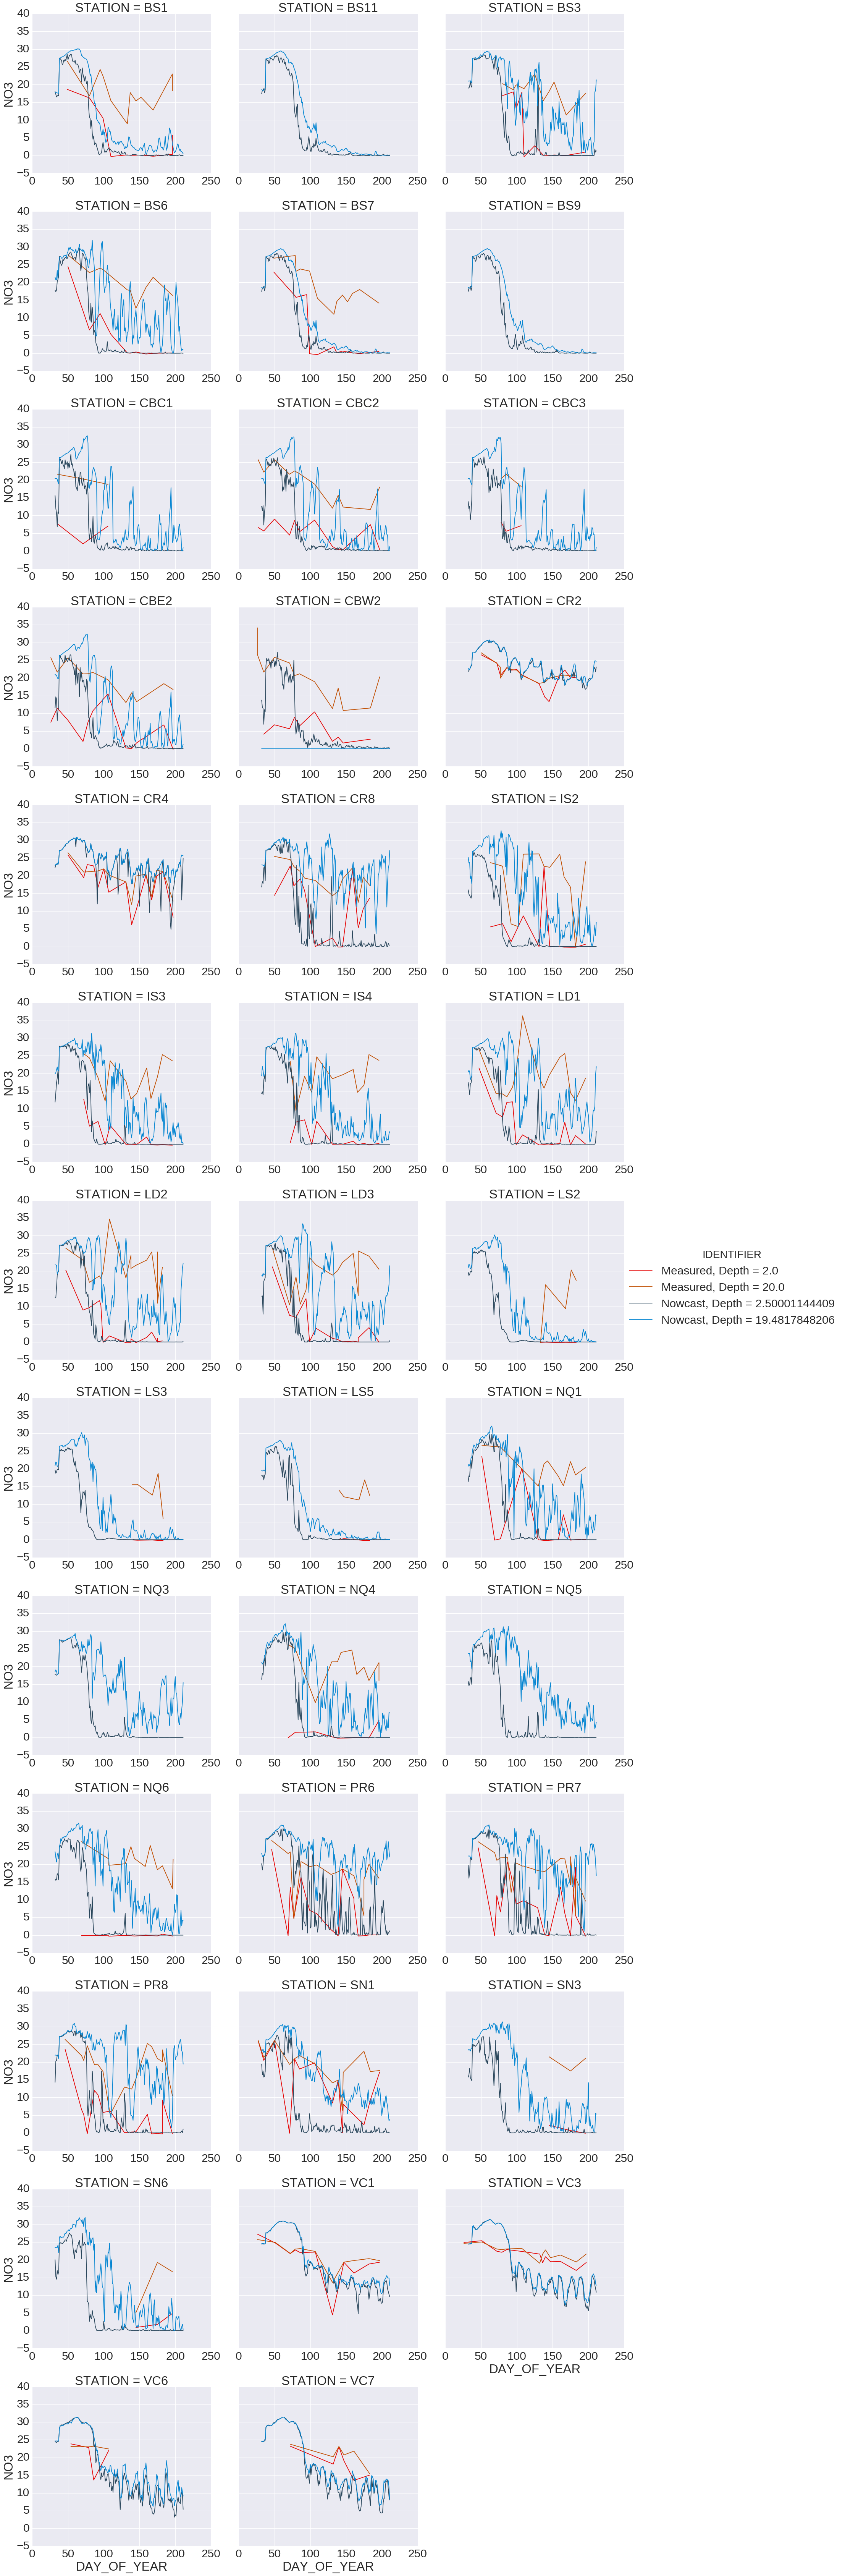

In [35]:
# Plot nowcast and measured nitrate data against day of year
# (simulation is for 2016 and data was collected in 2015)

colors = ["red","burnt orange", "dark grey blue", "cerulean",]
cmap = sns.xkcd_palette(colors)

sns.set(font_scale = 3)
fg = sns.FacetGrid(data = combined[(combined["DAY_OF_YEAR"] <= max(nowcast_df["DAY_OF_YEAR"]))], col = "STATION", col_wrap=3, hue = "IDENTIFIER", size =8, sharex = False, sharey = True, palette= cmap)
fg.map(plt.plot,"DAY_OF_YEAR", "NO3").add_legend()
#plt.xticks(rotation=45)
plt.subplots_adjust(top=0.9)

In [11]:
tracers = ["vosaline", "votemper"]
months = ['mar', 'apr', 'may']
hours = [12]
depth_indices = range(30)
nowcast_dir = "/results/SalishSea/nowcast-green/"
temp_salin = data_tools.load_nowcast_station_tracers(tracers, stations, months, hours, depth_indices, "grid_T.nc")

temp_salin["STATION"] = temp_salin["STATION"].apply(lambda x: x.strip())
temp_salin["DAY"] = [x.day for x in temp_salin.DATE]
temp_salin["DATE_STR"] = temp_salin["DATE"].apply(lambda temp_salin: temp_salin.strftime('%Y-%m-%d'))

Files loaded:1
Date of most recent nowcast load: 20160301
Time loading: 
0:00:33.390929
Files loaded:2
Date of most recent nowcast load: 20160302
Time loading: 
0:00:41.534818
Files loaded:3
Date of most recent nowcast load: 20160303
Time loading: 
0:00:49.773222
Files loaded:4
Date of most recent nowcast load: 20160304
Time loading: 
0:00:57.634617
Files loaded:5
Date of most recent nowcast load: 20160305
Time loading: 
0:01:05.550708
Files loaded:6
Date of most recent nowcast load: 20160306
Time loading: 
0:01:13.452218
Files loaded:7
Date of most recent nowcast load: 20160307
Time loading: 
0:01:21.297703
Files loaded:8
Date of most recent nowcast load: 20160308
Time loading: 
0:01:29.169913
Files loaded:9
Date of most recent nowcast load: 20160309
Time loading: 
0:01:37.132858
Files loaded:10
Date of most recent nowcast load: 20160310
Time loading: 
0:01:44.986017
Files loaded:11
Date of most recent nowcast load: 20160311
Time loading: 
0:01:52.868984
Files loaded:12
Date of most r

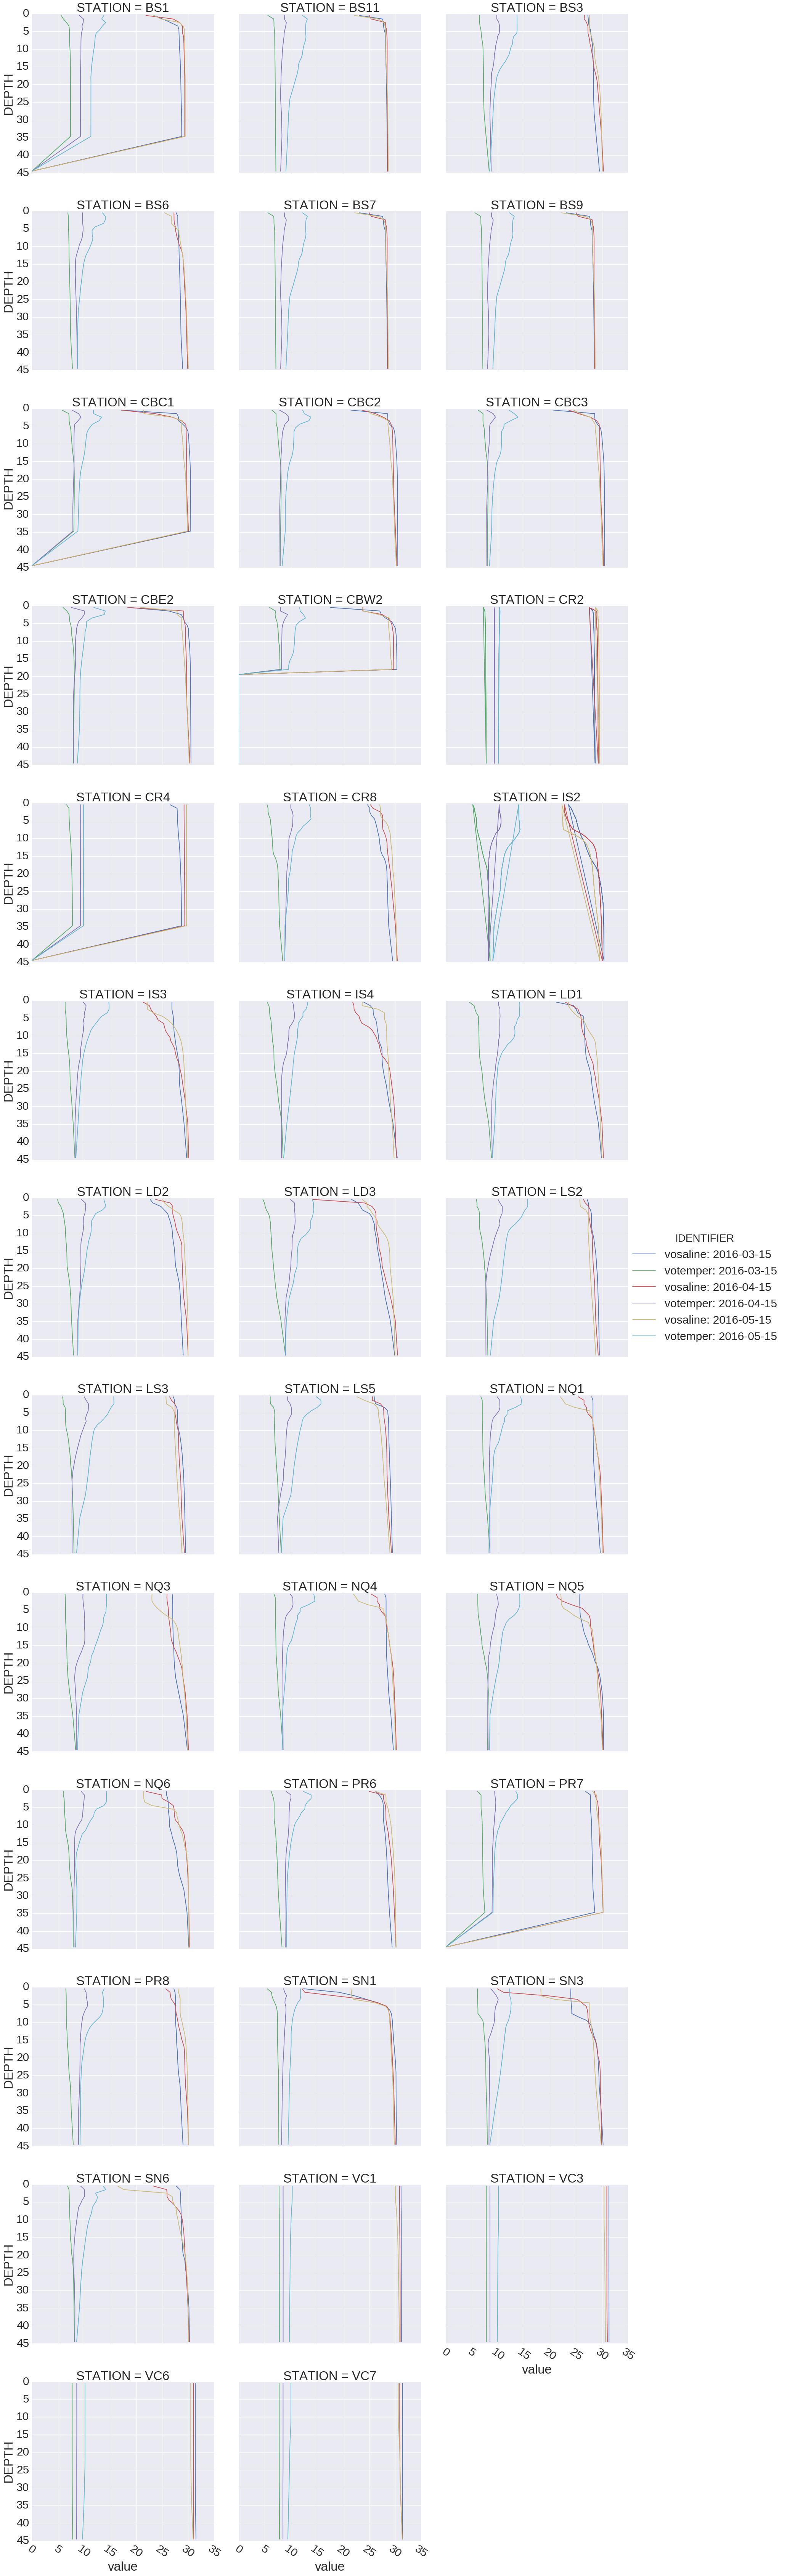

In [36]:
value_vars = ["vosaline", "votemper"]
long_format = pd.melt(temp_salin, id_vars = list(temp_salin.columns[~temp_salin.columns.isin(value_vars)]), value_vars = value_vars)
long_format["IDENTIFIER"] = long_format["variable"] + ": " + long_format["DATE_STR"]

long_format = long_format.sort_values(["STATION", "DATE"])

sns.set(font_scale = 3)
fg = sns.FacetGrid(data=long_format.query("DAY == 15 and DEPTH < 45"), hue="IDENTIFIER",col = "STATION",col_wrap = 3, size =8, sharey = True)
fg.map(plt.plot,"value", "DEPTH" ).add_legend()

fg.set_xticklabels(rotation=-35)
plt.subplots_adjust(top=0.9)
plt.gca().invert_yaxis()

dict_keys(['VC7', 'LD1', 'NQ6', 'SN1', 'IS4', 'NQ1', 'CR4', 'IS3', 'VC3', 'BS1', 'LD2', 'PR7', 'BS9', 'LS5', 'PR8', 'LD3', 'CBE2', 'CBC3', 'BS3', 'BS7', 'CR2', 'CBC2', 'VC1', 'LS3', 'VC6', 'PR6', 'LS2', 'BS11', 'CBC1', 'NQ5', 'NQ4', 'IS2 ', 'IS2', 'BS6', 'CBW2', 'SN6', 'CR8', 'NQ3', 'SN3', '               CR2'])